In [1]:
!pip3 install jsonpath-ng requests ipyplot tifffile

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import json
import urllib.request
import jsonpath_ng 
from jsonpath_ng import jsonpath
from jsonpath_ng.ext import parse
from IPython.display import display, Markdown
import tifffile
import ipyplot
from PIL import Image, ImageColor
import numpy as np

### Get Study

In [3]:
def get_ftp_path(accession):
    '''
    To avoid slowing down of directory operations, the FTP path for each study is structured as 
    a first level directory which is generally the accession prefix without any numbers and then 
    a second level directory which is last three zero padded digits (000 if the last character 
    is not a digit, e.g., S-BIAD would be under the relative path S-BIAD/007/S-BIAD7
    '''
    prefix = accession.rstrip('0123456789').rstrip('-')
    number = accession.replace(prefix, '').lstrip('-')
    number = int(number)%1000 if number.isdigit() else 0
    return '{prefix}/{number:03d}/{accession}'.format( prefix=prefix, number=number, accession=accession)

def display_attributes(attributes):
    attribute_html = list(map( lambda node: '<tr><td><b>{}</b></td><td style="text-align:left">{}</td></tr>'.format(node['name'], node['value']) ,attributes ))
    display(Markdown('<table>{}</table>'.format("".join(attribute_html))))


In [4]:
prefix = 'ftp://ftp.biostudies.ebi.ac.uk/biostudies-test/nfs'
study_ftp_pattern = '{prefix}/{path}'
study_url_pattern = '{study_root}/{accession}.json'

accession = 'S-BIAD7'
study_root = study_ftp_pattern.format( prefix = prefix, path = get_ftp_path(accession) )
# temp replacement of first level directory -- the folloing line will be deleted after reorganisation of FTP folders
study_root = study_root.replace('007','S-BIAD0-99')

study_url = study_url_pattern.format( study_root = study_root, accession = accession)

print ('Downloading study from ', study_url)

In [5]:
# Download the study json and display basic info
study_file = accession + '.json'
urllib.request.urlretrieve(study_url, study_file)
with open(study_file, 'r') as myfile:
    data=myfile.read()
study = json.loads(data)
study_attributes = parse('$.attributes').find(study)[0].value
study_attributes = study_attributes + parse('$.section.attributes').find(study)[0].value
display_attributes(study_attributes)

<table><tr><td><b>Title</b></td><td style="text-align:left">High-throughput microscopy exposes a pharmacological window in which dual leucine zipper kinase inhibition preserves neuronal network connectivity</td></tr><tr><td><b>ReleaseDate</b></td><td style="text-align:left">2019-05-16</td></tr><tr><td><b>AttachTo</b></td><td style="text-align:left">BioImages</td></tr><tr><td><b>Description</b></td><td style="text-align:left">Using a high-throughput microscopy pipeline, we found that inhibition of dual leucine zipper kinase (DLK) increased neuronal connectivity in primary cortical cultures.</td></tr><tr><td><b>Study type</b></td><td style="text-align:left">High-content confocal microscopy</td></tr><tr><td><b>Study Organism</b></td><td style="text-align:left">Mus Musculus</td></tr><tr><td><b>Number of Experiments</b></td><td style="text-align:left">2</td></tr></table>

### Download the large image

#### Get image name

#### ExperimentA

<table><tr><td><b>Title</b></td><td style="text-align:left">ExperimentA</td></tr><tr><td><b>Description</b></td><td style="text-align:left">Cortical and hippocampal primary cultures were fixed at different days in vitro (3, 7,10,14 and 18 DIV). Cultures were immunocytochemically labeled for a nuclear marker (DAPI; channel 1), neurite marker (MAP2, channel 2), a postsynaptic marker (PSD-95; channel 3) and a presynaptic marker (Synaptophysin; channel 4). We found that culture age correlates with morphological changes in primary neuronal networks.</td></tr><tr><td><b>Experiment size</b></td><td style="text-align:left">4D images: 900</td></tr><tr><td><b>Experiment Imaging Method</b></td><td style="text-align:left">Confocal microscopy</td></tr><tr><td><b>Experiment Technology Type</b></td><td style="text-align:left">ICC</td></tr><tr><td><b>Experimental conditions</b></td><td style="text-align:left">Control</td></tr><tr><td><b>Organism</b></td><td style="text-align:left">Mus Musculus</td></tr><tr><td><b>Experimental Condition</b></td><td style="text-align:left">B27_1:1</td></tr><tr><td><b>Channels</b></td><td style="text-align:left">405 nm (DAPI), 488 nm (MAP2), 561 nm (PSD-95) and 640 nm (Synaptophysin)</td></tr></table>

##### Rep1_DIV3_Cortical_r02c04f01.tiff


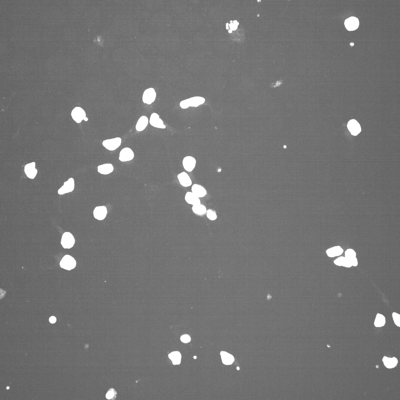
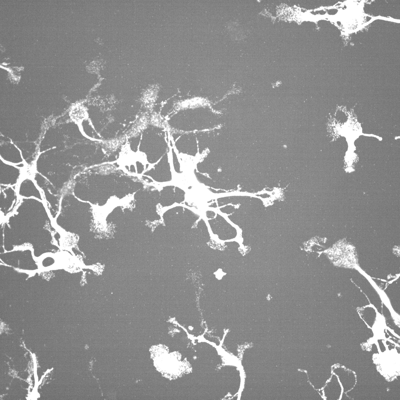
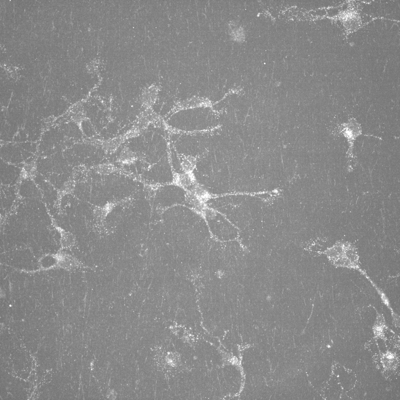
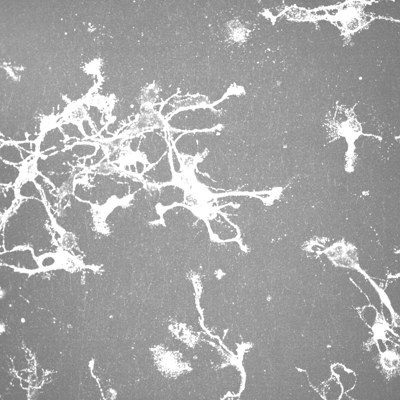


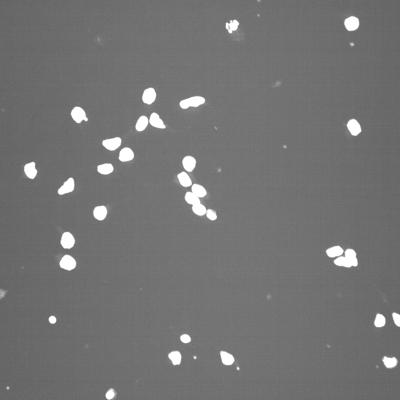
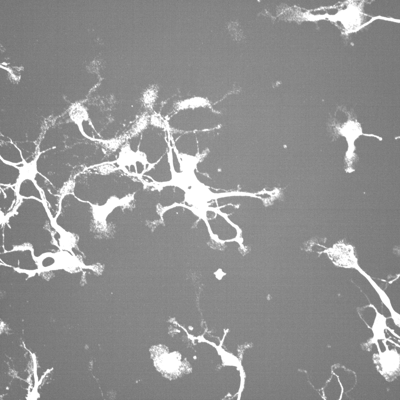
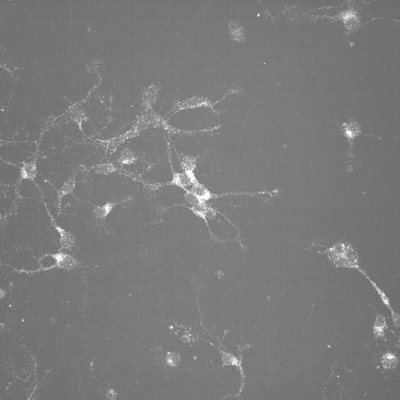
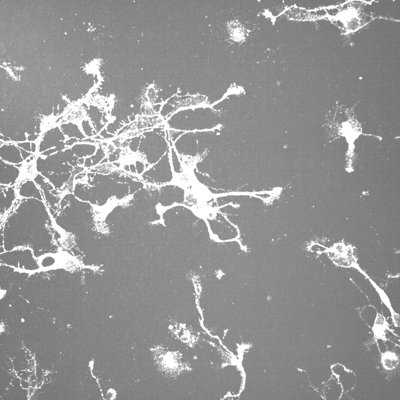


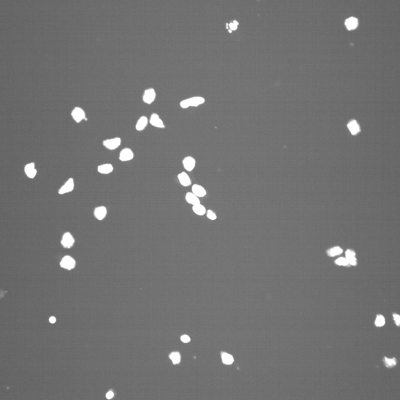
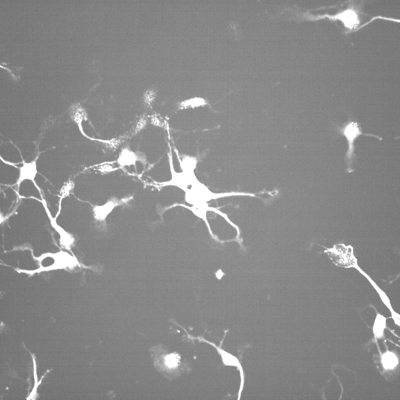
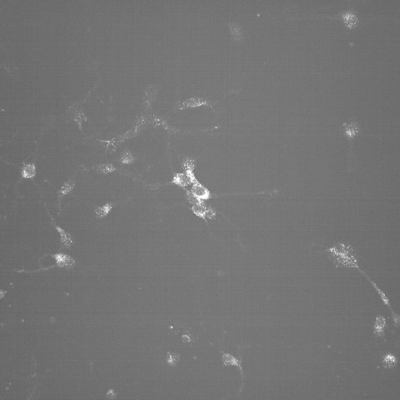
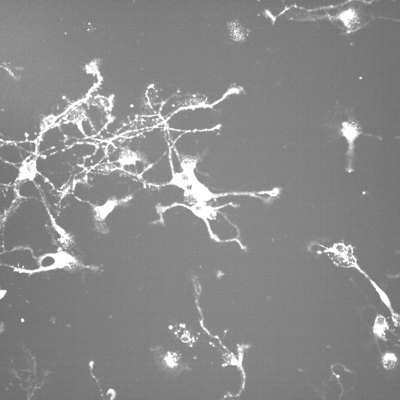

#### ExperimentB

<table><tr><td><b>Title</b></td><td style="text-align:left">ExperimentB</td></tr><tr><td><b>Description</b></td><td style="text-align:left">Dual leucine kinase (DLK) inhibition prevents neurodegeneration induced by hTau.P301L overexpression in primary cortical cultures. Cultures were immunocytochemically labeled for a neurite marker (MAP2), a presynaptic marker (Synaptophysin), a postsynaptic marker (PSD-95) and a nuclear marker (DAPI).</td></tr><tr><td><b>Experiment size</b></td><td style="text-align:left">4D images: 270</td></tr><tr><td><b>Experiment Imaging Method</b></td><td style="text-align:left">Confocal microscopy</td></tr><tr><td><b>Experiment Technology Type</b></td><td style="text-align:left">ICC</td></tr><tr><td><b>Experimental conditions</b></td><td style="text-align:left">Control, hTau.P301L overexpression and treated with GNE8505 (Dual leucine zipper kinase inhibitor)</td></tr><tr><td><b>Organism</b></td><td style="text-align:left">Mus Musculus</td></tr><tr><td><b>Primary Culture Type</b></td><td style="text-align:left">Cortical</td></tr><tr><td><b>Experimental Condition</b></td><td style="text-align:left">B27_1:1</td></tr><tr><td><b>Channels</b></td><td style="text-align:left">405 nm (DAPI), 488 nm (MAP2), 561 nm (PSD-95) and 640 nm (Synaptophysin)</td></tr></table>

##### Rep2_DIV14_Cortical_r07c06f15.tiff


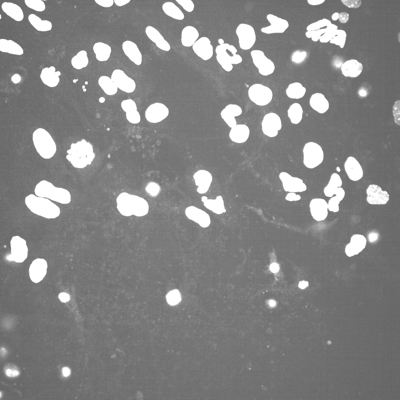
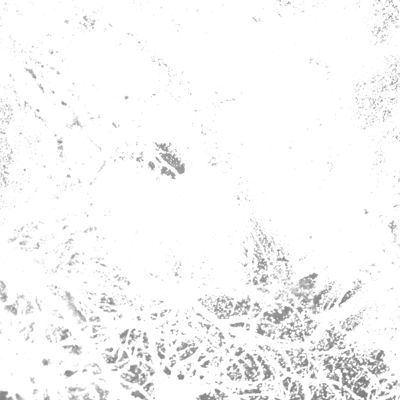
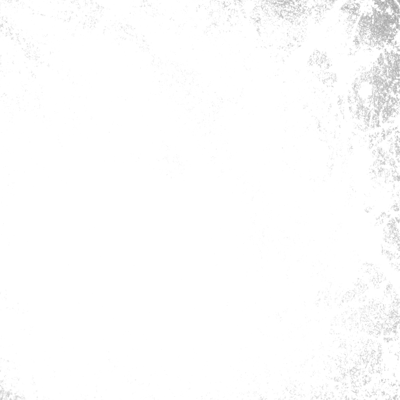
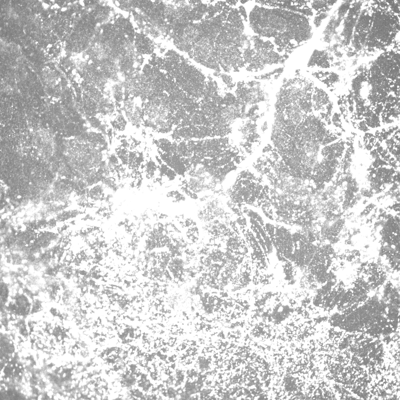


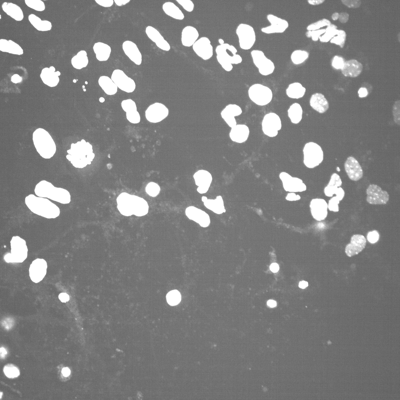
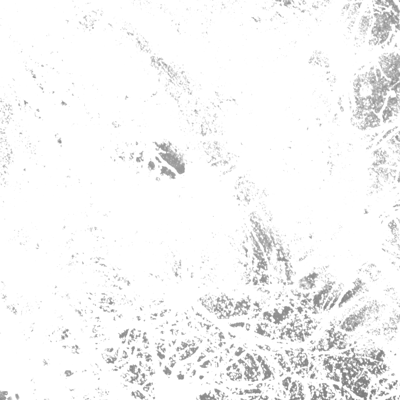
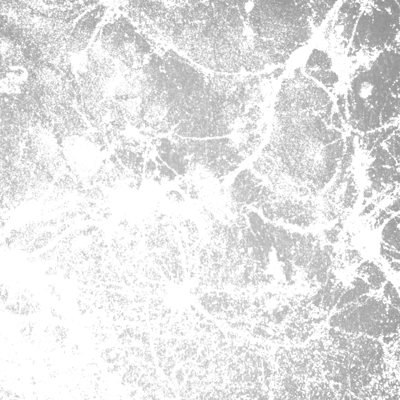
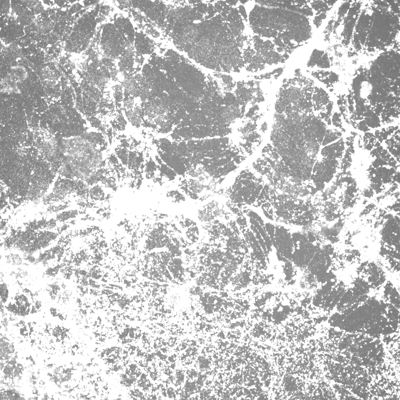


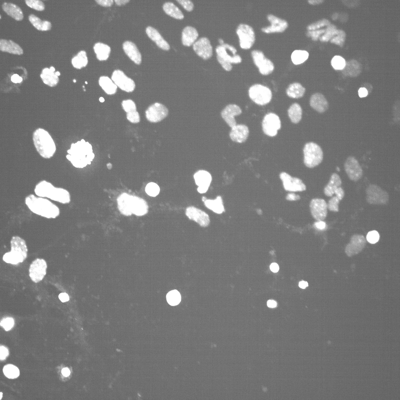
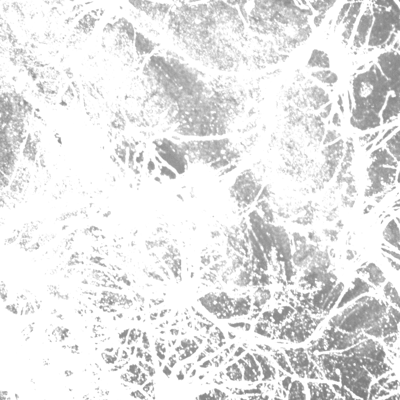
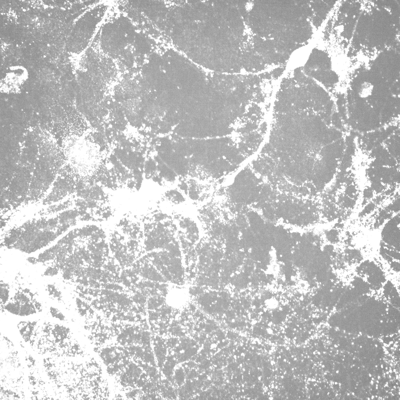
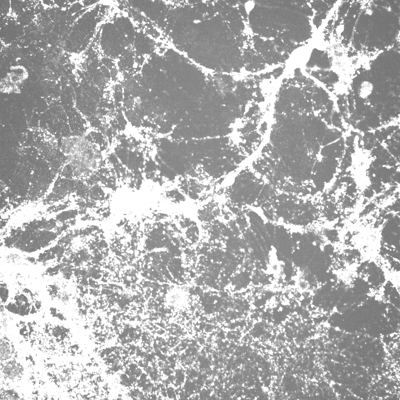


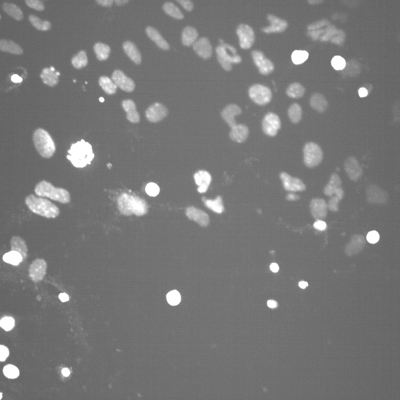
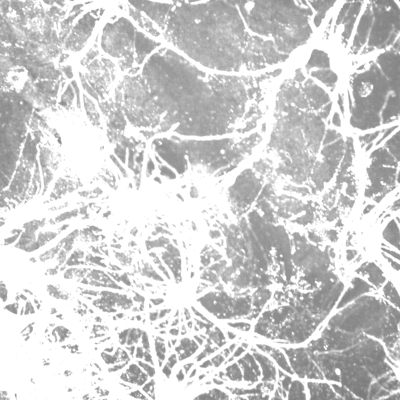
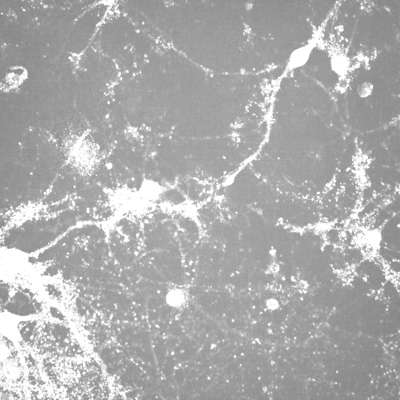
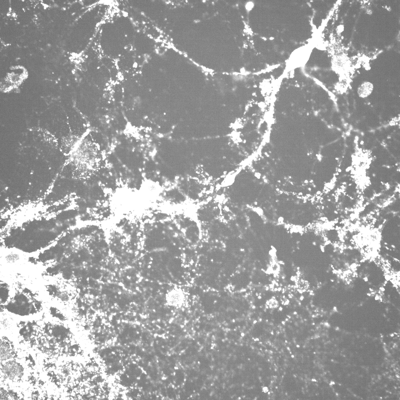

In [17]:
# Loop through each experiment 
experiments = parse('$..subsections[?(@.type=="Experiment")]').find(study)
images=[]
labels=[]
    
for experiment in experiments:
    display(Markdown('#### {}'.format( experiment.value['accno'])))
    display_attributes( experiment.value['attributes'] )

    #This study has files inside the main JSON
    filenames = parse('`this`..[*][?(@.type)]').find(experiment)
    
    #download the first image for each experiment
    filepath = filenames[0].value['path']
    ftp_url = '{study_root}/Files/{filepath}'.format(study_root = study_root, filepath = filepath)
    image_file = ftp_url.split('/')[-1]
    display(Markdown('##### {}'.format(image_file)))
    urllib.request.urlretrieve(ftp_url, image_file)
    
    with tifffile.TiffFile(image_file) as tif:   
        #print (json.dumps(tif.imagej_metadata, indent=4))
        slices = int(tif.imagej_metadata['slices'])
        channels = int(tif.imagej_metadata['channels'])

        for slice in range(0, slices):        
            images = []
            labels = []
            for channel in range(0, channels):
                images.append(Image.fromarray(tif.pages[slice*channels+channel].asarray()).convert('RGB')) 
                labels.append( 'Slice {} - Channel {}'.format(slice, channel)) 
            ipyplot.plot_images(images, labels, img_width=200)


